In [3]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F 
import sklearn
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable
from torchvision import utils
from IPython import embed

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
transform=transforms.Compose([transforms.ToTensor(), 
                              transforms.Normalize((0.5,), (0.5))])

mnist_trainset = datasets.MNIST(root='./DATA', train=True, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./DATA/MNIST/raw/train-images-idx3-ubyte.gz to ./DATA/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./DATA/MNIST/raw/train-labels-idx1-ubyte.gz to ./DATA/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./DATA/MNIST/raw/t10k-images-idx3-ubyte.gz to ./DATA/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./DATA/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./DATA/MNIST/raw



In [6]:
batchsize = 128
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batchsize, shuffle=True)

print("Training dataset size: ", len(mnist_trainset))
print("Training dataloader size: ", len(train_dataloader))

Training dataset size:  60000
Training dataloader size:  469


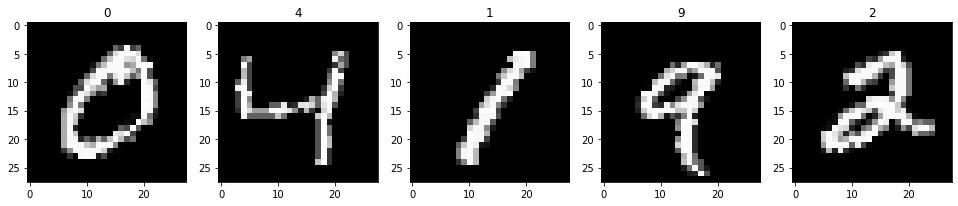

In [7]:
# visualize data
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage()(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img, cmap = "gray")
plt.show()

In [8]:
img, label=mnist_trainset[1]
print(img.shape,label)

torch.Size([1, 28, 28]) 0


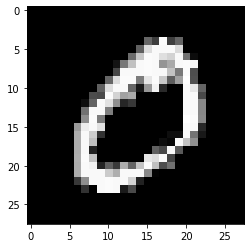

In [9]:
img = transforms.ToPILImage()(img)
plt.imshow(img, cmap="gray")

In [10]:
def denorm(image):
    return image * 0.5 + 0.5

def show_images(images, nmax=128):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(utils.make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataloader, nmax=128):
    for images, _ in dataloader:
        print(images.shape)
        show_images(images, nmax)
        break

In [11]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show_fig=False, epoch=0):
    image_unflat = image_tensor.detach().cpu()
    image_grid = utils.make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
        
    plt.show()

torch.Size([128, 1, 28, 28])


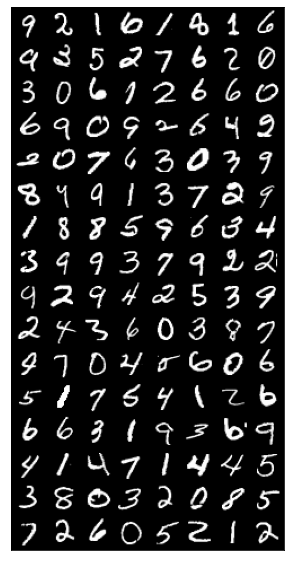

In [12]:
show_batch(train_dataloader)

In [13]:
num_classes = 10
z_d = 64 #noise size

In [14]:
def get_C_v_matrix(labels, train_batchsize):
    C_v = torch.zeros((train_batchsize,10,1))
    for i in range(train_batchsize):
      C_v[i,labels[i],:] = 1
    return C_v

In [15]:
def get_C_m_matrix(labels, train_batchsize):
  C_m = torch.zeros(train_batchsize,10, 28, 28)
  for i in range(train_batchsize):
    C_m[i,labels[i],:,:] = 1
  return C_m

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.ConvTranspose2d(74, 64, kernel_size=3, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.ConvTranspose2d(64, 128, kernel_size=4, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=0)
        self.bn4 = nn.BatchNorm2d(1)

    def forward(self, z):            # z = [128, 74, 1, 1]
        x = self.conv1(z)     # [128, 64, 3, 3]
        x = self.bn1(x)
        x = torch.tanh(x)
        x = self.conv2(x)       #([128, 128, 6, 6])
        x = self.bn2(x)
        x = torch.tanh(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.tanh(x)      #[128, 64, 13, 13]
        x = self.conv4(x)         # [128, 1, 28, 28]
        x = self.bn4(x)
        x = torch.relu(x)
        return x

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(11, 64, kernel_size=4, stride=2, padding=0)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=0)
        self.bn3 = nn.BatchNorm2d(1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.sigmoid(x)
        return x

In [25]:
generator = Generator().to(device) 
discriminator = Discriminator().to(device) 

In [26]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [27]:
generator.apply(weights_init)

Generator(
  (conv1): ConvTranspose2d(74, 64, kernel_size=(3, 3), stride=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
  (bn4): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [28]:
discriminator.apply(weights_init)

Discriminator(
  (conv1): Conv2d(11, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 1, kernel_size=(4, 4), stride=(2, 2))
  (bn3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [29]:
criterion = nn.BCEWithLogitsLoss()
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [30]:
num_epochs = 10

generator_loss = []
discriminator_loss = []

lossG_mean = []
lossD_mean = []
cur_steps = 0
total_steps = 0


[Epoch 1/10] [Batch 1/469] [D loss: 1.4594] [G loss: 0.4818]
[Epoch 1/10] [Batch 2/469] [D loss: 1.4548] [G loss: 0.4839]
[Epoch 1/10] [Batch 3/469] [D loss: 1.4525] [G loss: 0.4840]
[Epoch 1/10] [Batch 4/469] [D loss: 1.4500] [G loss: 0.4845]
[Epoch 1/10] [Batch 5/469] [D loss: 1.4489] [G loss: 0.4842]
[Epoch 1/10] [Batch 6/469] [D loss: 1.4408] [G loss: 0.4850]
[Epoch 1/10] [Batch 7/469] [D loss: 1.4430] [G loss: 0.4856]
[Epoch 1/10] [Batch 8/469] [D loss: 1.4408] [G loss: 0.4854]
[Epoch 1/10] [Batch 9/469] [D loss: 1.4440] [G loss: 0.4859]
[Epoch 1/10] [Batch 10/469] [D loss: 1.4405] [G loss: 0.4862]
[Epoch 1/10] [Batch 11/469] [D loss: 1.4401] [G loss: 0.4855]
[Epoch 1/10] [Batch 12/469] [D loss: 1.4378] [G loss: 0.4862]
[Epoch 1/10] [Batch 13/469] [D loss: 1.4332] [G loss: 0.4869]
[Epoch 1/10] [Batch 14/469] [D loss: 1.4331] [G loss: 0.4866]
[Epoch 1/10] [Batch 15/469] [D loss: 1.4356] [G loss: 0.4870]
[Epoch 1/10] [Batch 16/469] [D loss: 1.4353] [G loss: 0.4868]
[Epoch 1/10] [Bat

[Epoch 1/10] [Batch 468/469] [D loss: 1.4336] [G loss: 0.4959]
[Epoch 1/10] [Batch 469/469] [D loss: 1.4387] [G loss: 0.4956]


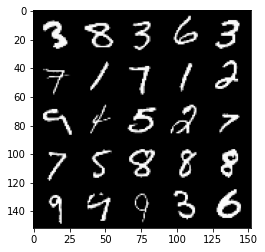

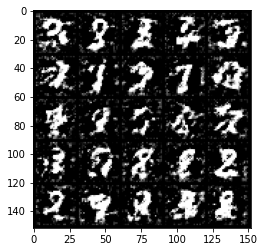

[Epoch 2/10] [Batch 1/469] [D loss: 1.4346] [G loss: 0.4938]
[Epoch 2/10] [Batch 2/469] [D loss: 1.4306] [G loss: 0.4950]
[Epoch 2/10] [Batch 3/469] [D loss: 1.4293] [G loss: 0.4959]
[Epoch 2/10] [Batch 4/469] [D loss: 1.4308] [G loss: 0.4909]
[Epoch 2/10] [Batch 5/469] [D loss: 1.4390] [G loss: 0.4960]
[Epoch 2/10] [Batch 6/469] [D loss: 1.4329] [G loss: 0.4963]
[Epoch 2/10] [Batch 7/469] [D loss: 1.4388] [G loss: 0.4947]
[Epoch 2/10] [Batch 8/469] [D loss: 1.4330] [G loss: 0.4929]
[Epoch 2/10] [Batch 9/469] [D loss: 1.4334] [G loss: 0.4949]
[Epoch 2/10] [Batch 10/469] [D loss: 1.4302] [G loss: 0.4949]
[Epoch 2/10] [Batch 11/469] [D loss: 1.4288] [G loss: 0.4948]
[Epoch 2/10] [Batch 12/469] [D loss: 1.4345] [G loss: 0.4965]
[Epoch 2/10] [Batch 13/469] [D loss: 1.4413] [G loss: 0.4971]
[Epoch 2/10] [Batch 14/469] [D loss: 1.4382] [G loss: 0.4961]
[Epoch 2/10] [Batch 15/469] [D loss: 1.4377] [G loss: 0.4948]
[Epoch 2/10] [Batch 16/469] [D loss: 1.4336] [G loss: 0.4947]
[Epoch 2/10] [Bat

[Epoch 2/10] [Batch 468/469] [D loss: 1.4149] [G loss: 0.5063]
[Epoch 2/10] [Batch 469/469] [D loss: 1.4212] [G loss: 0.5061]


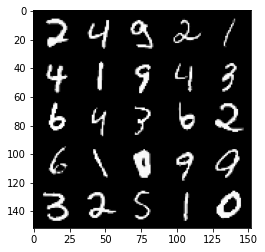

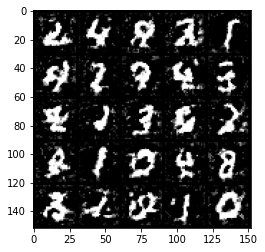

[Epoch 3/10] [Batch 1/469] [D loss: 1.4167] [G loss: 0.5048]
[Epoch 3/10] [Batch 2/469] [D loss: 1.4213] [G loss: 0.5060]
[Epoch 3/10] [Batch 3/469] [D loss: 1.4290] [G loss: 0.5035]
[Epoch 3/10] [Batch 4/469] [D loss: 1.4248] [G loss: 0.5057]
[Epoch 3/10] [Batch 5/469] [D loss: 1.4196] [G loss: 0.5053]
[Epoch 3/10] [Batch 6/469] [D loss: 1.4173] [G loss: 0.5057]
[Epoch 3/10] [Batch 7/469] [D loss: 1.4216] [G loss: 0.5064]
[Epoch 3/10] [Batch 8/469] [D loss: 1.4263] [G loss: 0.5040]
[Epoch 3/10] [Batch 9/469] [D loss: 1.4231] [G loss: 0.5048]
[Epoch 3/10] [Batch 10/469] [D loss: 1.4219] [G loss: 0.5068]
[Epoch 3/10] [Batch 11/469] [D loss: 1.4343] [G loss: 0.5033]
[Epoch 3/10] [Batch 12/469] [D loss: 1.4203] [G loss: 0.5051]
[Epoch 3/10] [Batch 13/469] [D loss: 1.4170] [G loss: 0.5068]
[Epoch 3/10] [Batch 14/469] [D loss: 1.4263] [G loss: 0.5048]
[Epoch 3/10] [Batch 15/469] [D loss: 1.4183] [G loss: 0.5064]
[Epoch 3/10] [Batch 16/469] [D loss: 1.4173] [G loss: 0.5038]
[Epoch 3/10] [Bat

[Epoch 3/10] [Batch 466/469] [D loss: 1.4192] [G loss: 0.5115]
[Epoch 3/10] [Batch 467/469] [D loss: 1.4201] [G loss: 0.5161]
[Epoch 3/10] [Batch 468/469] [D loss: 1.4250] [G loss: 0.5139]
[Epoch 3/10] [Batch 469/469] [D loss: 1.4174] [G loss: 0.5130]


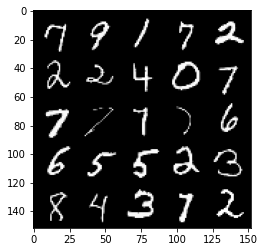

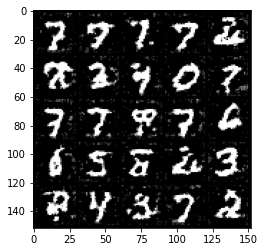

[Epoch 4/10] [Batch 1/469] [D loss: 1.4132] [G loss: 0.5162]
[Epoch 4/10] [Batch 2/469] [D loss: 1.4263] [G loss: 0.5148]
[Epoch 4/10] [Batch 3/469] [D loss: 1.4146] [G loss: 0.5136]
[Epoch 4/10] [Batch 4/469] [D loss: 1.4160] [G loss: 0.5164]
[Epoch 4/10] [Batch 5/469] [D loss: 1.4250] [G loss: 0.5125]
[Epoch 4/10] [Batch 6/469] [D loss: 1.4163] [G loss: 0.5136]
[Epoch 4/10] [Batch 7/469] [D loss: 1.4165] [G loss: 0.5156]
[Epoch 4/10] [Batch 8/469] [D loss: 1.4148] [G loss: 0.5135]
[Epoch 4/10] [Batch 9/469] [D loss: 1.4146] [G loss: 0.5154]
[Epoch 4/10] [Batch 10/469] [D loss: 1.4135] [G loss: 0.5141]
[Epoch 4/10] [Batch 11/469] [D loss: 1.4203] [G loss: 0.5106]
[Epoch 4/10] [Batch 12/469] [D loss: 1.4265] [G loss: 0.5151]
[Epoch 4/10] [Batch 13/469] [D loss: 1.4191] [G loss: 0.5161]
[Epoch 4/10] [Batch 14/469] [D loss: 1.4159] [G loss: 0.5152]
[Epoch 4/10] [Batch 15/469] [D loss: 1.4093] [G loss: 0.5158]
[Epoch 4/10] [Batch 16/469] [D loss: 1.4164] [G loss: 0.5119]
[Epoch 4/10] [Bat

[Epoch 4/10] [Batch 468/469] [D loss: 1.4147] [G loss: 0.5202]
[Epoch 4/10] [Batch 469/469] [D loss: 1.4124] [G loss: 0.5228]


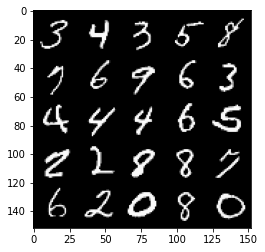

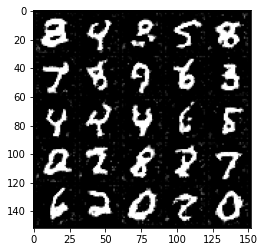

[Epoch 5/10] [Batch 1/469] [D loss: 1.4136] [G loss: 0.5235]
[Epoch 5/10] [Batch 2/469] [D loss: 1.4115] [G loss: 0.5190]
[Epoch 5/10] [Batch 3/469] [D loss: 1.4198] [G loss: 0.5237]
[Epoch 5/10] [Batch 4/469] [D loss: 1.4243] [G loss: 0.5245]
[Epoch 5/10] [Batch 5/469] [D loss: 1.4196] [G loss: 0.5226]
[Epoch 5/10] [Batch 6/469] [D loss: 1.4130] [G loss: 0.5238]
[Epoch 5/10] [Batch 7/469] [D loss: 1.4174] [G loss: 0.5225]
[Epoch 5/10] [Batch 8/469] [D loss: 1.4109] [G loss: 0.5237]
[Epoch 5/10] [Batch 9/469] [D loss: 1.4198] [G loss: 0.5190]
[Epoch 5/10] [Batch 10/469] [D loss: 1.4211] [G loss: 0.5252]
[Epoch 5/10] [Batch 11/469] [D loss: 1.4209] [G loss: 0.5254]
[Epoch 5/10] [Batch 12/469] [D loss: 1.4156] [G loss: 0.5214]
[Epoch 5/10] [Batch 13/469] [D loss: 1.4158] [G loss: 0.5223]
[Epoch 5/10] [Batch 14/469] [D loss: 1.4114] [G loss: 0.5231]
[Epoch 5/10] [Batch 15/469] [D loss: 1.4243] [G loss: 0.5169]
[Epoch 5/10] [Batch 16/469] [D loss: 1.4260] [G loss: 0.5249]
[Epoch 5/10] [Bat

[Epoch 5/10] [Batch 468/469] [D loss: 1.4120] [G loss: 0.5309]
[Epoch 5/10] [Batch 469/469] [D loss: 1.4032] [G loss: 0.5287]


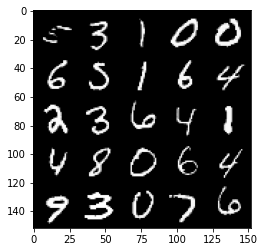

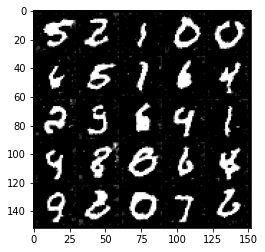

[Epoch 6/10] [Batch 1/469] [D loss: 1.4153] [G loss: 0.5297]
[Epoch 6/10] [Batch 2/469] [D loss: 1.4040] [G loss: 0.5325]
[Epoch 6/10] [Batch 3/469] [D loss: 1.4084] [G loss: 0.5261]
[Epoch 6/10] [Batch 4/469] [D loss: 1.4090] [G loss: 0.5327]
[Epoch 6/10] [Batch 5/469] [D loss: 1.4139] [G loss: 0.5310]
[Epoch 6/10] [Batch 6/469] [D loss: 1.4103] [G loss: 0.5296]
[Epoch 6/10] [Batch 7/469] [D loss: 1.4045] [G loss: 0.5329]
[Epoch 6/10] [Batch 8/469] [D loss: 1.4124] [G loss: 0.5299]
[Epoch 6/10] [Batch 9/469] [D loss: 1.4059] [G loss: 0.5303]
[Epoch 6/10] [Batch 10/469] [D loss: 1.4094] [G loss: 0.5329]
[Epoch 6/10] [Batch 11/469] [D loss: 1.4102] [G loss: 0.5257]
[Epoch 6/10] [Batch 12/469] [D loss: 1.4123] [G loss: 0.5321]
[Epoch 6/10] [Batch 13/469] [D loss: 1.4060] [G loss: 0.5325]
[Epoch 6/10] [Batch 14/469] [D loss: 1.4038] [G loss: 0.5307]
[Epoch 6/10] [Batch 15/469] [D loss: 1.4025] [G loss: 0.5308]
[Epoch 6/10] [Batch 16/469] [D loss: 1.4126] [G loss: 0.5327]
[Epoch 6/10] [Bat

[Epoch 6/10] [Batch 467/469] [D loss: 1.4077] [G loss: 0.5337]
[Epoch 6/10] [Batch 468/469] [D loss: 1.4094] [G loss: 0.5391]
[Epoch 6/10] [Batch 469/469] [D loss: 1.4190] [G loss: 0.5404]


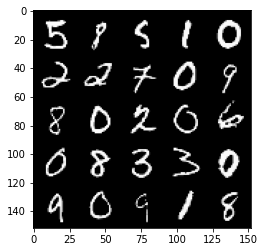

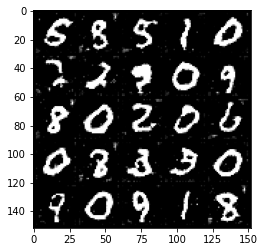

[Epoch 7/10] [Batch 1/469] [D loss: 1.4142] [G loss: 0.5344]
[Epoch 7/10] [Batch 2/469] [D loss: 1.4093] [G loss: 0.5350]
[Epoch 7/10] [Batch 3/469] [D loss: 1.4109] [G loss: 0.5377]
[Epoch 7/10] [Batch 4/469] [D loss: 1.4037] [G loss: 0.5400]
[Epoch 7/10] [Batch 5/469] [D loss: 1.4077] [G loss: 0.5364]
[Epoch 7/10] [Batch 6/469] [D loss: 1.3972] [G loss: 0.5382]
[Epoch 7/10] [Batch 7/469] [D loss: 1.4036] [G loss: 0.5406]
[Epoch 7/10] [Batch 8/469] [D loss: 1.4106] [G loss: 0.5381]
[Epoch 7/10] [Batch 9/469] [D loss: 1.4062] [G loss: 0.5371]
[Epoch 7/10] [Batch 10/469] [D loss: 1.4017] [G loss: 0.5389]
[Epoch 7/10] [Batch 11/469] [D loss: 1.4065] [G loss: 0.5393]
[Epoch 7/10] [Batch 12/469] [D loss: 1.4115] [G loss: 0.5353]
[Epoch 7/10] [Batch 13/469] [D loss: 1.4101] [G loss: 0.5341]
[Epoch 7/10] [Batch 14/469] [D loss: 1.4087] [G loss: 0.5396]
[Epoch 7/10] [Batch 15/469] [D loss: 1.4015] [G loss: 0.5401]
[Epoch 7/10] [Batch 16/469] [D loss: 1.4065] [G loss: 0.5349]
[Epoch 7/10] [Bat

[Epoch 7/10] [Batch 466/469] [D loss: 1.4034] [G loss: 0.5450]
[Epoch 7/10] [Batch 467/469] [D loss: 1.4035] [G loss: 0.5451]
[Epoch 7/10] [Batch 468/469] [D loss: 1.3997] [G loss: 0.5464]
[Epoch 7/10] [Batch 469/469] [D loss: 1.4118] [G loss: 0.5328]


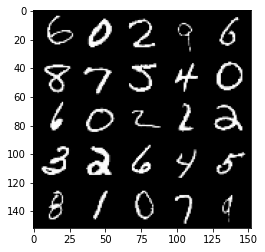

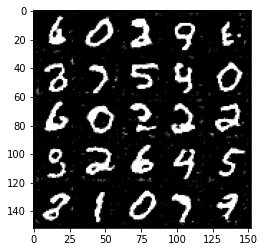

[Epoch 8/10] [Batch 1/469] [D loss: 1.4072] [G loss: 0.5485]
[Epoch 8/10] [Batch 2/469] [D loss: 1.3993] [G loss: 0.5471]
[Epoch 8/10] [Batch 3/469] [D loss: 1.3996] [G loss: 0.5481]
[Epoch 8/10] [Batch 4/469] [D loss: 1.4085] [G loss: 0.5421]
[Epoch 8/10] [Batch 5/469] [D loss: 1.3998] [G loss: 0.5468]
[Epoch 8/10] [Batch 6/469] [D loss: 1.4034] [G loss: 0.5427]
[Epoch 8/10] [Batch 7/469] [D loss: 1.3984] [G loss: 0.5466]
[Epoch 8/10] [Batch 8/469] [D loss: 1.4111] [G loss: 0.5393]
[Epoch 8/10] [Batch 9/469] [D loss: 1.4120] [G loss: 0.5473]
[Epoch 8/10] [Batch 10/469] [D loss: 1.4071] [G loss: 0.5443]
[Epoch 8/10] [Batch 11/469] [D loss: 1.3995] [G loss: 0.5400]
[Epoch 8/10] [Batch 12/469] [D loss: 1.4100] [G loss: 0.5466]
[Epoch 8/10] [Batch 13/469] [D loss: 1.3984] [G loss: 0.5448]
[Epoch 8/10] [Batch 14/469] [D loss: 1.3949] [G loss: 0.5481]
[Epoch 8/10] [Batch 15/469] [D loss: 1.4148] [G loss: 0.5477]
[Epoch 8/10] [Batch 16/469] [D loss: 1.4158] [G loss: 0.5481]
[Epoch 8/10] [Bat

[Epoch 8/10] [Batch 466/469] [D loss: 1.3988] [G loss: 0.5524]
[Epoch 8/10] [Batch 467/469] [D loss: 1.4083] [G loss: 0.5484]
[Epoch 8/10] [Batch 468/469] [D loss: 1.3975] [G loss: 0.5495]
[Epoch 8/10] [Batch 469/469] [D loss: 1.4074] [G loss: 0.5538]


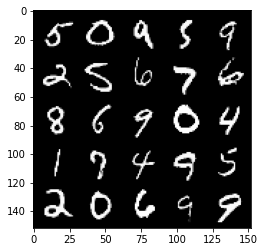

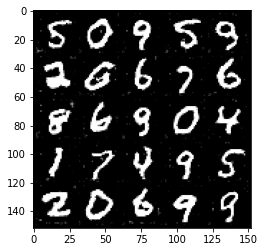

[Epoch 9/10] [Batch 1/469] [D loss: 1.4176] [G loss: 0.5528]
[Epoch 9/10] [Batch 2/469] [D loss: 1.4192] [G loss: 0.5496]
[Epoch 9/10] [Batch 3/469] [D loss: 1.4084] [G loss: 0.5490]
[Epoch 9/10] [Batch 4/469] [D loss: 1.4087] [G loss: 0.5476]
[Epoch 9/10] [Batch 5/469] [D loss: 1.4023] [G loss: 0.5513]
[Epoch 9/10] [Batch 6/469] [D loss: 1.4038] [G loss: 0.5530]
[Epoch 9/10] [Batch 7/469] [D loss: 1.4034] [G loss: 0.5509]
[Epoch 9/10] [Batch 8/469] [D loss: 1.3921] [G loss: 0.5480]
[Epoch 9/10] [Batch 9/469] [D loss: 1.4009] [G loss: 0.5565]
[Epoch 9/10] [Batch 10/469] [D loss: 1.4053] [G loss: 0.5542]
[Epoch 9/10] [Batch 11/469] [D loss: 1.4029] [G loss: 0.5504]
[Epoch 9/10] [Batch 12/469] [D loss: 1.3958] [G loss: 0.5545]
[Epoch 9/10] [Batch 13/469] [D loss: 1.3911] [G loss: 0.5533]
[Epoch 9/10] [Batch 14/469] [D loss: 1.3959] [G loss: 0.5537]
[Epoch 9/10] [Batch 15/469] [D loss: 1.4026] [G loss: 0.5504]
[Epoch 9/10] [Batch 16/469] [D loss: 1.3989] [G loss: 0.5552]
[Epoch 9/10] [Bat

[Epoch 9/10] [Batch 468/469] [D loss: 1.4122] [G loss: 0.5551]
[Epoch 9/10] [Batch 469/469] [D loss: 1.3956] [G loss: 0.5617]


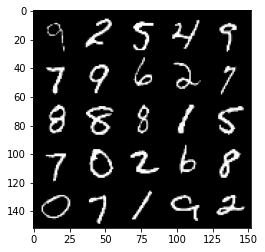

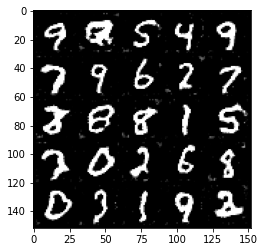

[Epoch 10/10] [Batch 1/469] [D loss: 1.3992] [G loss: 0.5554]
[Epoch 10/10] [Batch 2/469] [D loss: 1.3993] [G loss: 0.5598]
[Epoch 10/10] [Batch 3/469] [D loss: 1.4032] [G loss: 0.5591]
[Epoch 10/10] [Batch 4/469] [D loss: 1.4001] [G loss: 0.5603]
[Epoch 10/10] [Batch 5/469] [D loss: 1.3992] [G loss: 0.5574]
[Epoch 10/10] [Batch 6/469] [D loss: 1.3987] [G loss: 0.5609]
[Epoch 10/10] [Batch 7/469] [D loss: 1.4123] [G loss: 0.5526]
[Epoch 10/10] [Batch 8/469] [D loss: 1.4042] [G loss: 0.5592]
[Epoch 10/10] [Batch 9/469] [D loss: 1.3979] [G loss: 0.5568]
[Epoch 10/10] [Batch 10/469] [D loss: 1.3932] [G loss: 0.5598]
[Epoch 10/10] [Batch 11/469] [D loss: 1.3937] [G loss: 0.5621]
[Epoch 10/10] [Batch 12/469] [D loss: 1.4043] [G loss: 0.5558]
[Epoch 10/10] [Batch 13/469] [D loss: 1.3993] [G loss: 0.5598]
[Epoch 10/10] [Batch 14/469] [D loss: 1.3959] [G loss: 0.5561]
[Epoch 10/10] [Batch 15/469] [D loss: 1.3983] [G loss: 0.5595]
[Epoch 10/10] [Batch 16/469] [D loss: 1.4027] [G loss: 0.5603]
[

[Epoch 10/10] [Batch 466/469] [D loss: 1.3977] [G loss: 0.5419]
[Epoch 10/10] [Batch 467/469] [D loss: 1.4128] [G loss: 0.5615]
[Epoch 10/10] [Batch 468/469] [D loss: 1.3940] [G loss: 0.5676]
[Epoch 10/10] [Batch 469/469] [D loss: 1.3987] [G loss: 0.5676]


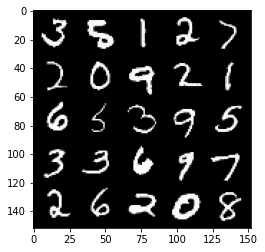

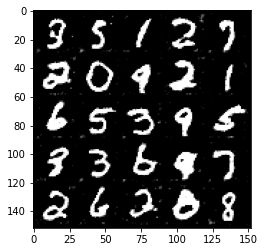

In [33]:
for epoch in range(num_epochs):
    cur_steps = 0
    for i, (real_images, labels) in enumerate(train_dataloader):
        
        real_images = real_images.to(device) 
        labels = labels.to(device) 
        
        optimizer_d.zero_grad()
        batchsize = len(labels)
        # Train discriminator on fake images
        noise = torch.randn((batchsize, z_d,1))      #[128, 64, 1]
        C_v = get_C_v_matrix(labels, batchsize)      #([128, 10, 1])
        gen_input = torch.cat((noise, C_v), dim =1).to(device) 
        gen_input = gen_input.reshape((batchsize, 74,1,1))  #([128, 74, 1,1])

        fake_images = generator(gen_input).to(device)       #[128, 1, 28, 28]
        C_m = get_C_m_matrix(labels, batchsize).to(device)      #[128, 10, 28, 28]
        disc_input = torch.cat((fake_images,C_m ), dim =1).to(device)       #[128, 11, 28, 28]
        
        pred_fake = discriminator(disc_input.detach()).to(device)        # 128, 1, 1, 1]
        fake_labels = torch.zeros_like(pred_fake).to(device)         #[128, 1, 1, 1]
        loss_D_fake = criterion(pred_fake, fake_labels)

        # Train discriminator on real images
        disc_input_r = torch.cat((real_images,C_m),dim =1).to(device) 
        pred_real = discriminator(disc_input_r).to(device) 
        real_labels = torch.ones_like(pred_real).to(device) 
        loss_D_real = criterion(pred_real, real_labels)

        # Total discriminator loss and backpropagation
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_d.step()

        discriminator_loss.append(loss_D)

        # Train generator
        generator.zero_grad()
        pred_fake = discriminator(disc_input).to(device) 
        loss_G = criterion(pred_fake, real_labels)
        loss_G.backward()
        optimizer_g.step()

        generator_loss.append(loss_G)
        cur_steps += 1
        total_steps += 1

        # Output training stats
        print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i+1}/{len(train_dataloader)}] [D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")  
        

    fake_images = generator(gen_input) 
    show_tensor_images(real_images, show_fig=True, epoch=epoch) 
    show_tensor_images(fake_images, show_fig=True, epoch=epoch) 
    gen_mean = sum(generator_loss[-cur_steps:]) / cur_steps
    disc_mean = sum(discriminator_loss[-cur_steps:]) / cur_steps

    lossG_mean.append(gen_mean) 
    lossG_mean.append(disc_mean) 

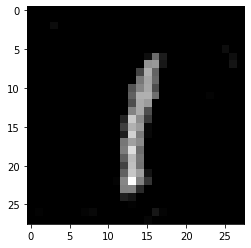

In [34]:
plt.imshow(fake_images[9].cpu().detach().permute(1,2,0),cmap="gray")

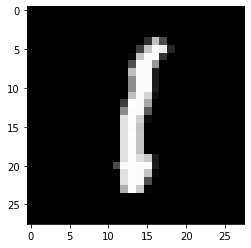

In [35]:
plt.imshow(real_images[9].cpu().detach().permute(1,2,0),cmap="gray")

In [51]:
generator_loss = torch.tensor(generator_loss).detach().cpu().numpy()
discriminator_loss= torch.tensor(discriminator_loss).detach().cpu().numpy()

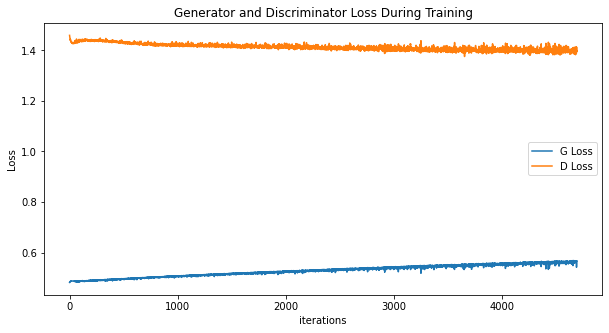

In [52]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(generator_loss,label="G Loss")
plt.plot(discriminator_loss,label="D Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()